#Testing on Different Anamoally Detection
To test the capabilities of the model, we tried testing it on other imbalanced datasets.
But after spending a lot of time on configuring and tweaking, we werent able to achieve a good results and hence decided not to include it in our report

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Load the dataset
file_path = '/content/dataset 2.csv'  # Update with your original dataset path
dataset = pd.read_csv(file_path)

# Handle missing values
for column in dataset.columns:
    if dataset[column].dtype in ['float64', 'int64']:
        dataset[column].fillna(dataset[column].median(), inplace=True)
    else:
        dataset[column].fillna(dataset[column].mode()[0], inplace=True)

# Initialize label encoders for each categorical column
label_encoders = {
    column: LabelEncoder().fit(dataset[column].astype(str))
    for column in ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
}

# Apply the label encoders to the dataset
for column, encoder in label_encoders.items():
    dataset[column] = encoder.transform(dataset[column].astype(str))

# Converting the 'stroke' column to string
dataset['stroke'] = dataset['stroke'].astype(str)

# Save the preprocessed dataset to a CSV file
preprocessed_file_path = '/content/dataset 3.csv'  # Update with your desired file path
dataset.to_csv(preprocessed_file_path, index=False)

print(f"Dataset preprocessed and saved to {preprocessed_file_path}")


Dataset preprocessed and saved to /content/dataset 3.csv


In [3]:
import csv
import torch
from torch.utils.data.dataset import Dataset

torch.manual_seed(0)  # for reproducibility

class SplitedDataSet(Dataset):
    def __init__(self, mode="non-stroke"):
        DATA_DIRECTORY = '/content/dataset 3.csv'  # Update with your dataset path

        # data loading
        self.features = []
        self.labels = []
        csvData = open(DATA_DIRECTORY)
        data = csv.reader(csvData)

        if mode == 'stroke':
            skipped_class = '0'
        elif mode == 'non-stroke':
            skipped_class = '1'

        for row in data:
            if row[-1] == skipped_class or row[-1] == 'stroke':
                continue
            self.features.append(row[:-1])
            self.labels.append(row[-1])

        # convert elements from string to float
        for i in range(len(self.features)):
            self.features[i] = list(map(float, self.features[i]))
        self.labels = list(map(float, self.labels))

    def __getitem__(self, index):
        return self.features[index], self.labels[index]

    def __len__(self):
        assert len(self.features) == len(self.labels), print('data length error')
        return len(self.features)

class DataSet(Dataset):
    def __init__(self, datasets=[]):
        self.features = []
        self.labels = []

        for dataset in datasets:
            self.features += [dataset[i][0][1:-1] for i in range(len(dataset))]
            self.labels += [dataset[i][1] for i in range(len(dataset))]

        self.features = torch.FloatTensor(self.features)
        self.labels = torch.FloatTensor(self.labels)

    def __getitem__(self, index):
        return self.features[index], self.labels[index]

    def __len__(self):
        assert len(self.features) == len(self.labels), print('data length error')
        return len(self.features)


In [4]:
import torch
from torch.utils.data import random_split
import csv
import random

torch.manual_seed(4)  # for reproducibility
random.seed(0)

def getDatasets():
    non_fraud_Data = SplitedDataSet(mode = 'non-stroke')
    fraud_Data = SplitedDataSet(mode = 'stroke')

    data_point_num = len(non_fraud_Data)
    print(len(fraud_Data))
    test_data_point_num = 780
    train_data_point_num = data_point_num - test_data_point_num
    trainData, nonFraudTestData = random_split(non_fraud_Data, [train_data_point_num, test_data_point_num])
    l = len(fraud_Data) - test_data_point_num
    trainData = DataSet([trainData])
    fraud_Data, _ = random_split(fraud_Data, [780, l])
    testData = DataSet([nonFraudTestData, fraud_Data]) #following the setting of 13.pdf

    return trainData, testData

def writeToCsv():
    trainData, testData = getDatasets()
    with open("./datasets/trainData.csv", "w") as f:
        writer = csv.writer(f)

        for i in range(len(trainData)):
            writer.writerow(trainData[i][0].tolist() + [trainData[i][1]])

    with open("./datasets/testData.csv", "w") as f:
        writer = csv.writer(f)

        for i in range(len(testData)):
            writer.writerow(testData[i][0].tolist() + [testData[i][1]])


In [5]:
import torch
import torch.nn as nn

#torch.manual_seed(0)#for reproducibility

def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.xavier_uniform_(m.weight.data)
    elif classname.find('Linear') != -1:
        nn.init.normal_(m.weight.data)
        nn.init.constant_(m.bias.data, 0.0)
    elif classname.find('BatchNorm1d') != -1:
        nn.init.normal_(m.weight.data)
        nn.init.constant_(m.bias.data, 0.0)

def init_weights(net_layer):
    try:
        net_layer.apply(weights_init_normal)
    except:
        raise NotImplementedError('weights initialization error')


class FCNN(nn.Module):
    def __init__(self):
        super(FCNN, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(9, 4),
            nn.BatchNorm1d(4),
            nn.LeakyReLU(0.01, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(4, 2),
            nn.BatchNorm1d(2),
            nn.LeakyReLU(0.01, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(2, 1)
        )
        init_weights(self.layer)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.layer(x)
        x = self.sigmoid(x)
        return x

class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(9, 6),
            nn.BatchNorm1d(6),
            nn.LeakyReLU(0.01, inplace=True),
            nn.Linear(6, 3),
            nn.BatchNorm1d(3),
            nn.LeakyReLU(0.01, inplace=True)
        )
        init_weights(self.encoder)

        self.decoder = nn.Sequential(
            nn.Linear(3, 6),
            nn.BatchNorm1d(6),
            nn.LeakyReLU(0.01, inplace=True),
            nn.Linear(6, 9)
        )
        init_weights(self.decoder)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [6]:
import torch
import matplotlib.pyplot as plt


def plot_and_save_fig(fpr, tpr, roc_auc):
    plt.figure()
    plt.plot(fpr, tpr, color = 'darkorange', lw = 1, label='AUC = %0.4f'% roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw = 1, linestyle='--')
    plt.legend(loc='lower right')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.ion()
    plt.savefig('./fig/AUROC')
    plt.pause(2)
    plt.close()

def load_checkpoint(g_path, d_path):

    generator = autoencoder()
    discriminator = FCNN()

    g_checkpoint = torch.load(g_path)
    d_checkpoint = torch.load(d_path)

    g_optimizer = torch.optim.Adam(generator.parameters(), lr = 0.0002, weight_decay = 1e-3)
    d_optimizer = torch.optim.Adam(discriminator.parameters(), lr = 0.0002, weight_decay = 1e-3)

    g_optimizer.load_state_dict(g_checkpoint['optimizer_state_dict'])
    d_optimizer.load_state_dict(d_checkpoint['optimizer_state_dict'])

    generator.load_state_dict(g_checkpoint['model_state_dict'])
    discriminator.load_state_dict(d_checkpoint['model_state_dict'])

    assert g_checkpoint['epoch'] == d_checkpoint['epoch'], 'epoch number loading error'
    current_epoch = g_checkpoint['epoch']

    return generator, discriminator, g_optimizer, d_optimizer, current_epoch

def get_MCC(TP, FP, FN, TN):
    try:
        MCC = ( TP * TN - FP * FN) / ((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN)) ** (1/2)
        MCC = round(MCC, 4)
    except:
        MCC = 0
    return MCC

def get_accuracy(TP, FP, FN, TN):
    accuracy = (TP + TN) / (TP + FP + FN + TN)
    accuracy = round(accuracy, 4)
    return accuracy

def get_recall(TP, FP, FN, TN):
    try:
        recall = TP / (TP + FN)
        recall = round(recall, 4)
    except:
        recall = 'N/A'
    return recall

def get_precision(TP, FP, FN, TN):
    try:
        precision = TP / (TP + FP)
        precision = round(precision, 4)
    except:
        precision = 'N/A'
    return precision

def get_F1_score(TP, FP, FN, TN):
    try:
        recall = get_recall(TP = TP, FP = FP, FN = FN, TN = TN)
        precision = get_precision(TP = TP, FP = FP, FN = FN, TN = TN)
        F1_score = 2 / ((1 / recall) + (1 / precision))
        F1_score = round(F1_score, 4)
    except:
        F1_score = 'N/A'
    return F1_score


In [8]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn import metrics
import numpy as np
import random
#import lime
#import lime.lime_tabular

# Set parameters directly
batch_size = 512
lr = 1e-3
n_epochs = 5
normalization = 'z_score'
reconstructionLoss = 'SmoothL1'
mode = 'train'
GPU = False
resume = False
print(f"Parameters: batch_size={batch_size}, lr={lr}, n_epochs={n_epochs}, normalization={normalization}, reconstructionLoss={reconstructionLoss}, mode={mode}, GPU={GPU}, resume={resume}")

torch.manual_seed(4)  # for reproducibility
random.seed(0)

# load datasets
print(f'loading the {mode} dataset...')
trainData, testData = getDatasets()

trainDataLoader = DataLoader(dataset=trainData, batch_size=batch_size, shuffle=True, drop_last=True)
testDataLoader = DataLoader(dataset=testData, batch_size=batch_size, shuffle=True)
print('datasets loading finished!')

# load models
if os.path.exists('./checkpoints/g_checkpoint.pth') and os.path.exists('./checkpoints/d_checkpoint.pth') and (resume or mode == 'test'):
    try:
        print('loading existing (pretrained) models...')
        g_path = './checkpoints/g_checkpoint.pth'
        d_path = './checkpoints/d_checkpoint.pth'
        generator, discriminator, g_optimizer, d_optimizer, current_epoch = load_checkpoint(g_path, d_path)
    except:
        raise Exception('failed to load models. Please check the path')
else:
    print('building new models...')
    generator = autoencoder()
    discriminator = FCNN()

    g_optimizer = torch.optim.Adam(generator.parameters(), lr=lr, weight_decay=1e-4)
    d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr, weight_decay=1e-4)
    current_epoch = 0


generator.train()
discriminator.train()

if GPU and torch.cuda.is_available():
    print('using GPU...')
    generator = generator.cuda()
    discriminator = discriminator.cuda()

# some checks
if current_epoch >= n_epochs and mode == 'train':
    raise Exception('epoch number error!')
if mode == 'test' and (os.path.exists('./checkpoints/g_checkpoint.pth') and os.path.exists('./checkpoints/d_checkpoint.pth')) == False:
    raise Exception('no pretrained models for testing stage')

# setting the loss function
# setting re-construction loss
if reconstructionLoss == 'MSE':
    reconstructionLoss = nn.MSELoss()
elif reconstructionLoss == 'L1':
    reconstructionLoss = nn.L1Loss()
elif reconstructionLoss == 'SmoothL1':
    reconstructionLoss = nn.SmoothL1Loss()
elif reconstructionLoss == 'BCE':
    reconstructionLoss = nn.BCEWithLogitsLoss()
else:
    raise Exception('loss function setting error')

# setting adversarial loss
BCELoss = nn.BCEWithLogitsLoss()
MSELoss = nn.MSELoss()

g_loss_Re =0
g_loss_BCE =0
d_loss_sum = 0
TP, FP, FN, TN = 0, 0, 0, 0#4 elements of confusion metrix for calculating MCC

sig = nn.Sigmoid()


Parameters: batch_size=512, lr=0.001, n_epochs=5, normalization=z_score, reconstructionLoss=SmoothL1, mode=train, GPU=False, resume=False
loading the train dataset...
783
datasets loading finished!
building new models...


In [10]:
print('start running on train mode...')
for epoch in range(current_epoch, n_epochs):
    print('epoch:', epoch + 1)
    g_loss_Re =0
    g_loss_BCE =0
    d_loss_sum = 0
    for i, (features, labels) in enumerate(trainDataLoader):
        labels = labels.unsqueeze(1)
        if torch.sum(labels) != 0:
            raise Exception('stop')

        real_label = torch.ones(labels.size())
        fake_label = torch.zeros(labels.size())

        if GPU == True and torch.cuda.is_available():
            real_label = real_label.cuda()
            fake_label = fake_label.cuda()
            features = features.cuda()
            labels = labels.cuda()

        ##train Generator
        reconstruction = generator(features)
        Re_Loss = reconstructionLoss(reconstruction, features)
        fake_pred = discriminator(reconstruction)

        BCE_Loss = BCELoss(fake_pred, real_label)
        g_loss = Re_Loss + BCE_Loss
        g_loss = Re_Loss

        g_optimizer.zero_grad()
        g_loss.backward()

        '''nn.utils.clip_grad_norm_(MIX.parameters(), args.clipping_value)'''

        g_optimizer.step()

        g_loss_Re += torch.sum(Re_Loss)
        g_loss_BCE += torch.sum(Re_Loss)

        ##train discriminator
        real_pred = discriminator(features)
        real_loss = BCELoss(real_pred, real_label)

        fake_pred = discriminator(reconstruction.detach())
        fake_loss = BCELoss(fake_pred, fake_label)

        d_loss = real_loss + fake_loss

        d_optimizer.zero_grad()
        d_loss.backward()
        '''nn.utils.clip_grad_norm_(GRU.parameters(), args.clipping_value)'''
        d_optimizer.step()

        d_loss_sum += torch.sum(d_loss)


        if (i + 1) % 10 == 0:
            print("iteration: {} / {}, Epoch: {} / {}, g_loss_Re: {:.5f}, g_loss_BCE: {:.4f}, d_loss: {:.4f}".format(
                str((i+1)*batch_size), len(trainData), epoch+1, n_epochs, g_loss_Re.data / (500*batch_size), g_loss_BCE.data / (500*batch_size), d_loss_sum.data / (500*batch_size)))
            g_loss_Re = 0
            g_loss_BCE = 0
            d_loss_sum = 0
            #print('real_pred:', real_pred)
            #print('fake_pred:', fake_pred)



start running on train mode...
epoch: 1
iteration: 5120 / 41837, Epoch: 1 / 5, g_loss_Re: 0.00075, g_loss_BCE: 0.0008, d_loss: 0.0001
iteration: 10240 / 41837, Epoch: 1 / 5, g_loss_Re: 0.00075, g_loss_BCE: 0.0008, d_loss: 0.0001
iteration: 15360 / 41837, Epoch: 1 / 5, g_loss_Re: 0.00075, g_loss_BCE: 0.0007, d_loss: 0.0001
iteration: 20480 / 41837, Epoch: 1 / 5, g_loss_Re: 0.00074, g_loss_BCE: 0.0007, d_loss: 0.0001
iteration: 25600 / 41837, Epoch: 1 / 5, g_loss_Re: 0.00074, g_loss_BCE: 0.0007, d_loss: 0.0001
iteration: 30720 / 41837, Epoch: 1 / 5, g_loss_Re: 0.00075, g_loss_BCE: 0.0007, d_loss: 0.0001
iteration: 35840 / 41837, Epoch: 1 / 5, g_loss_Re: 0.00074, g_loss_BCE: 0.0007, d_loss: 0.0001
iteration: 40960 / 41837, Epoch: 1 / 5, g_loss_Re: 0.00074, g_loss_BCE: 0.0007, d_loss: 0.0001
epoch: 2
iteration: 5120 / 41837, Epoch: 2 / 5, g_loss_Re: 0.00074, g_loss_BCE: 0.0007, d_loss: 0.0001
iteration: 10240 / 41837, Epoch: 2 / 5, g_loss_Re: 0.00074, g_loss_BCE: 0.0007, d_loss: 0.0001
ite

start running on test mode...
threshold: 0.05
TP: 780.0
FP: 780.0
TN: 0.0
FN: 0.0


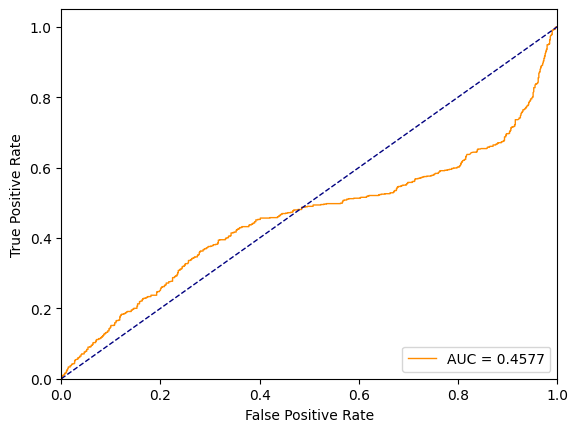

accuracy: 0.5, recall: 1.0, precision: 0.5, F1_score: 0.6667, MCC: 0
threshold: 0.1
TP: 780.0
FP: 780.0
TN: 0.0
FN: 0.0


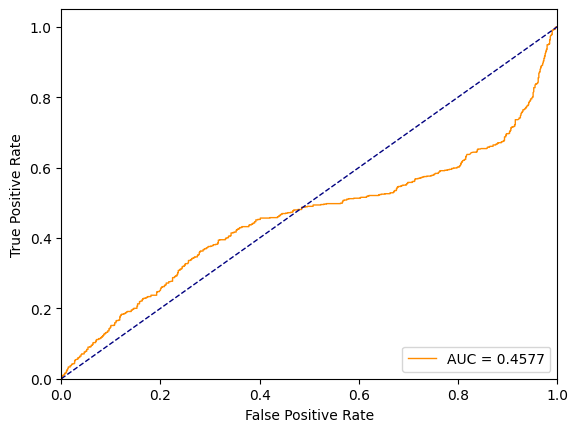

accuracy: 0.5, recall: 1.0, precision: 0.5, F1_score: 0.6667, MCC: 0
threshold: 0.15
TP: 780.0
FP: 780.0
TN: 0.0
FN: 0.0


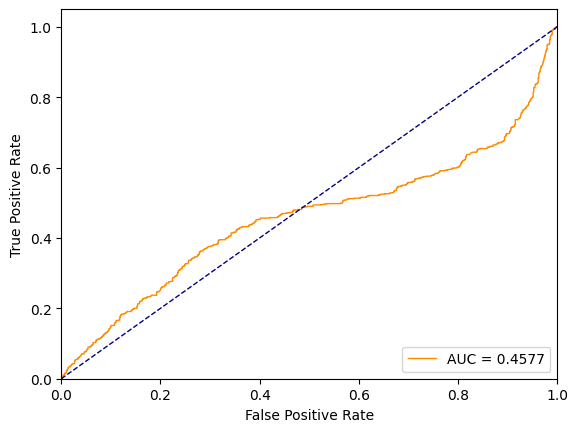

accuracy: 0.5, recall: 1.0, precision: 0.5, F1_score: 0.6667, MCC: 0
threshold: 0.2
TP: 780.0
FP: 780.0
TN: 0.0
FN: 0.0


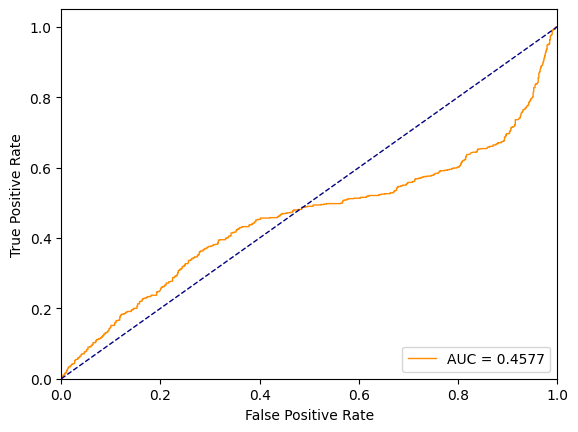

accuracy: 0.5, recall: 1.0, precision: 0.5, F1_score: 0.6667, MCC: 0
threshold: 0.25
TP: 780.0
FP: 780.0
TN: 0.0
FN: 0.0


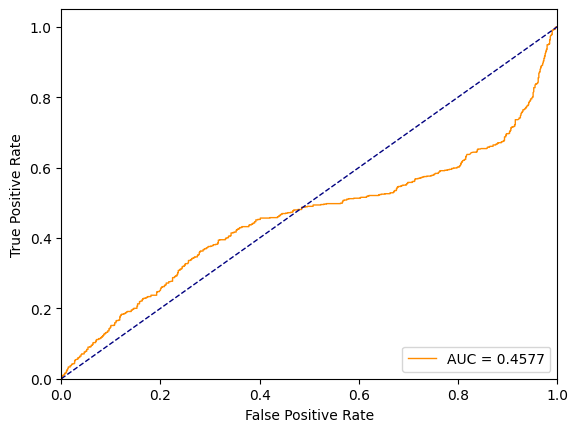

accuracy: 0.5, recall: 1.0, precision: 0.5, F1_score: 0.6667, MCC: 0
threshold: 0.3
TP: 780.0
FP: 780.0
TN: 0.0
FN: 0.0


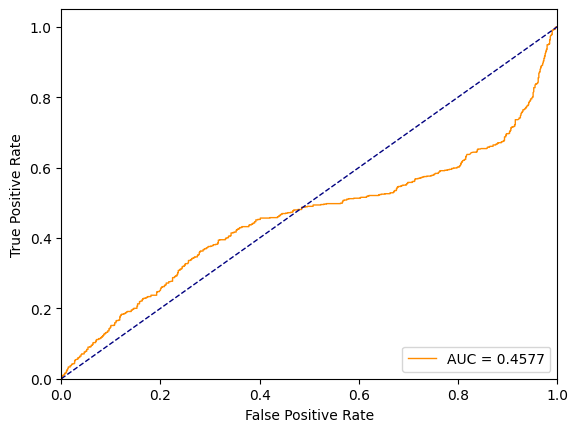

accuracy: 0.5, recall: 1.0, precision: 0.5, F1_score: 0.6667, MCC: 0
threshold: 0.35
TP: 780.0
FP: 780.0
TN: 0.0
FN: 0.0


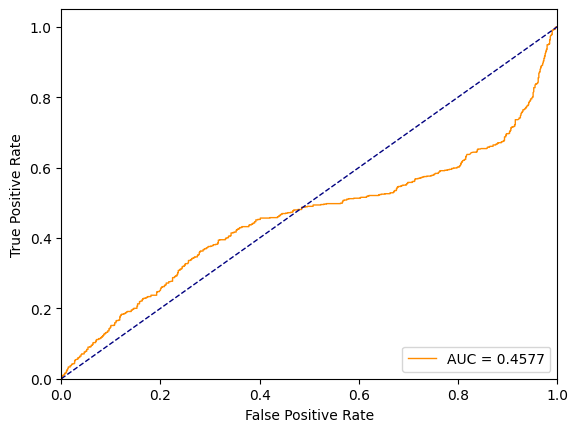

accuracy: 0.5, recall: 1.0, precision: 0.5, F1_score: 0.6667, MCC: 0
threshold: 0.4
TP: 780.0
FP: 780.0
TN: 0.0
FN: 0.0


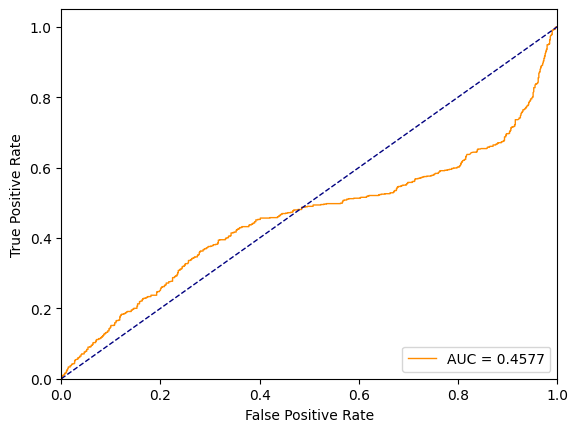

accuracy: 0.5, recall: 1.0, precision: 0.5, F1_score: 0.6667, MCC: 0
threshold: 0.45
TP: 780.0
FP: 780.0
TN: 0.0
FN: 0.0


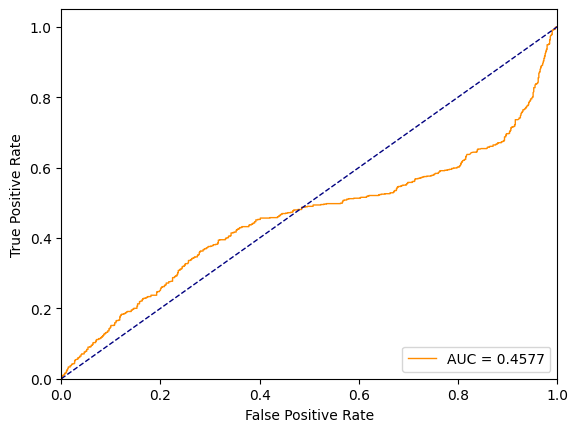

accuracy: 0.5, recall: 1.0, precision: 0.5, F1_score: 0.6667, MCC: 0
threshold: 0.5
TP: 780.0
FP: 780.0
TN: 0.0
FN: 0.0


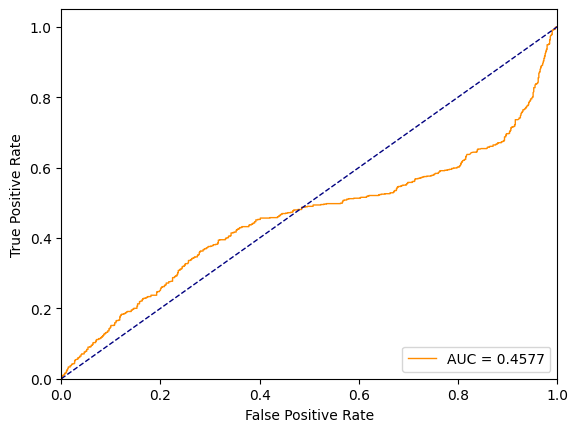

accuracy: 0.5, recall: 1.0, precision: 0.5, F1_score: 0.6667, MCC: 0
threshold: 0.55
TP: 780.0
FP: 780.0
TN: 0.0
FN: 0.0


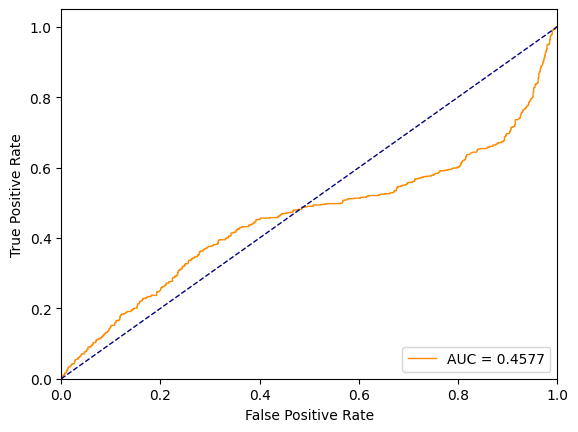

accuracy: 0.5, recall: 1.0, precision: 0.5, F1_score: 0.6667, MCC: 0
threshold: 0.6
TP: 0.0
FP: 0.0
TN: 780.0
FN: 780.0


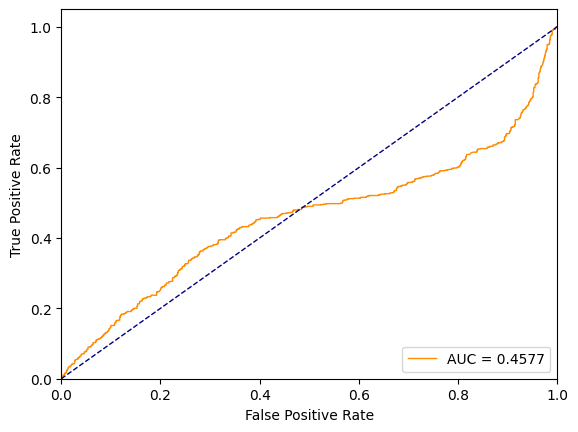

accuracy: 0.5, recall: 0.0, precision: N/A, F1_score: N/A, MCC: 0
threshold: 0.65
TP: 0.0
FP: 0.0
TN: 780.0
FN: 780.0


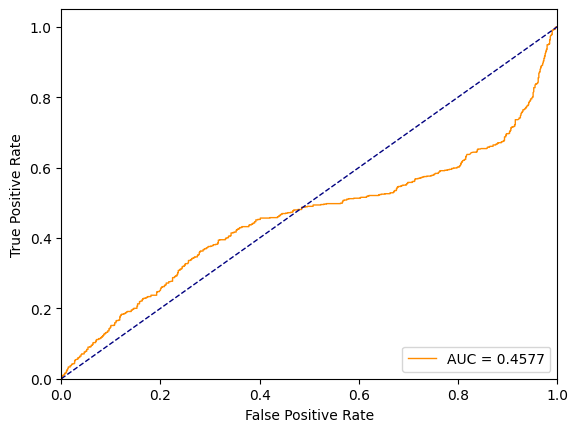

accuracy: 0.5, recall: 0.0, precision: N/A, F1_score: N/A, MCC: 0
threshold: 0.7
TP: 0.0
FP: 0.0
TN: 780.0
FN: 780.0


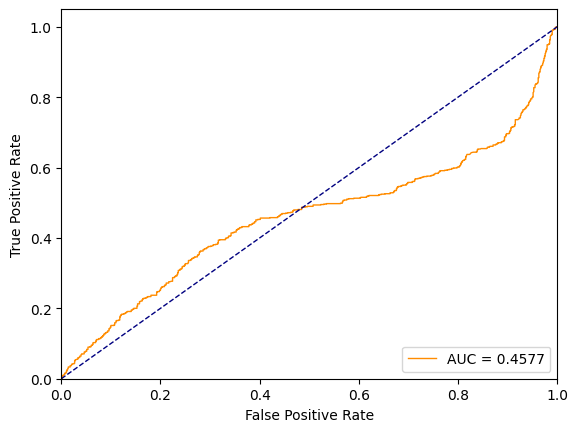

accuracy: 0.5, recall: 0.0, precision: N/A, F1_score: N/A, MCC: 0
threshold: 0.75
TP: 0.0
FP: 0.0
TN: 780.0
FN: 780.0


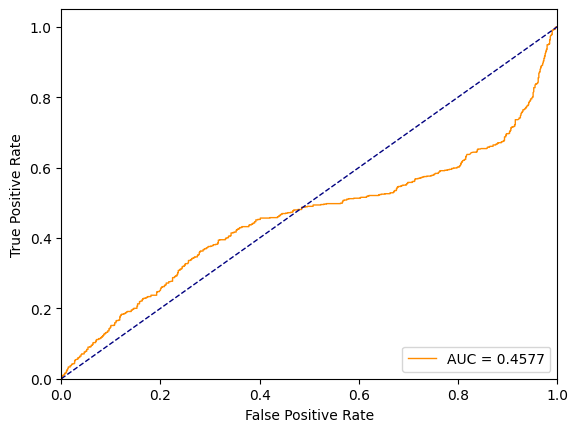

accuracy: 0.5, recall: 0.0, precision: N/A, F1_score: N/A, MCC: 0
threshold: 0.8
TP: 0.0
FP: 0.0
TN: 780.0
FN: 780.0


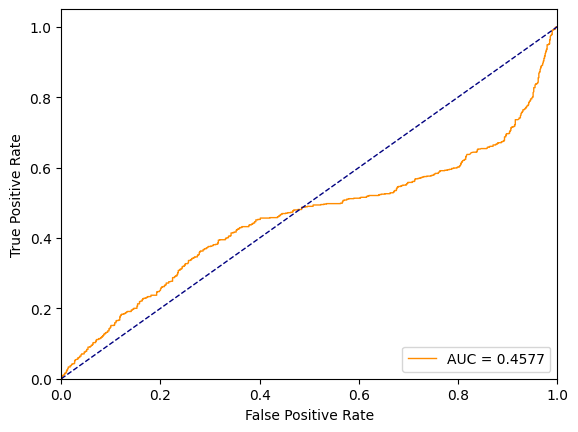

accuracy: 0.5, recall: 0.0, precision: N/A, F1_score: N/A, MCC: 0
threshold: 0.85
TP: 0.0
FP: 0.0
TN: 780.0
FN: 780.0


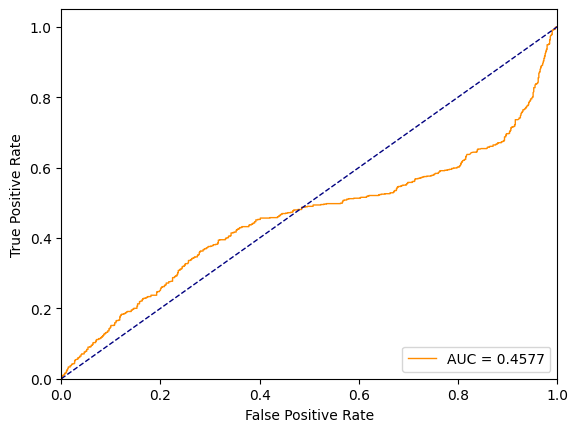

accuracy: 0.5, recall: 0.0, precision: N/A, F1_score: N/A, MCC: 0
threshold: 0.9
TP: 0.0
FP: 0.0
TN: 780.0
FN: 780.0


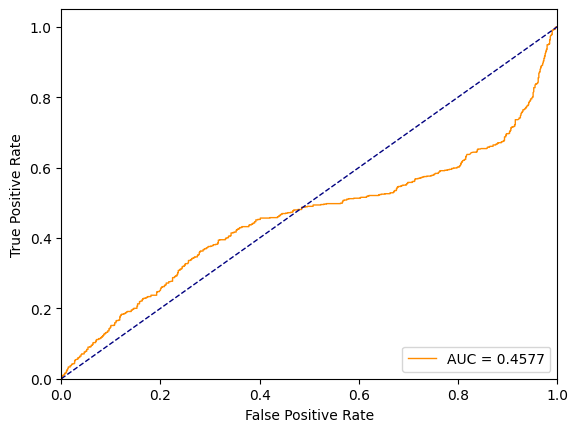

accuracy: 0.5, recall: 0.0, precision: N/A, F1_score: N/A, MCC: 0
threshold: 0.95
TP: 0.0
FP: 0.0
TN: 780.0
FN: 780.0


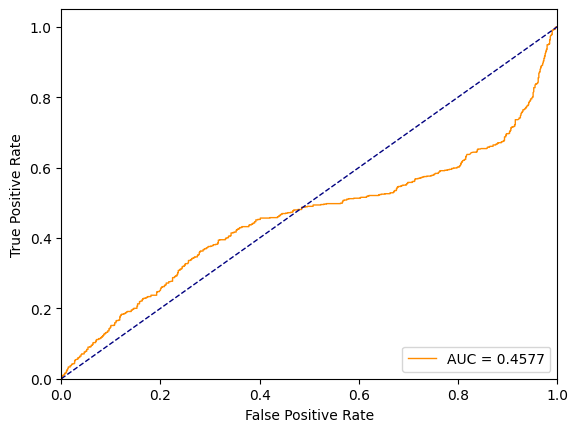

accuracy: 0.5, recall: 0.0, precision: N/A, F1_score: N/A, MCC: 0


In [12]:
generator.eval()
discriminator.eval()

print('start running on test mode...')
for i in range(1, 20):
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    all_pred = []
    all_labels = []
    threshold = i / 20
    print('threshold:', threshold)
    for i, (features, labels) in enumerate(testDataLoader):

        if GPU == True and torch.cuda.is_available():
            features = features.cuda()
            #noisy_features = noisy_features.cuda()
            labels = labels.cuda()

        ##test Discriminator
        reconstructed_features = generator(features)
        p_fraud = discriminator(reconstructed_features)
        p_fraud = sig(p_fraud)
        #print('re:', torch.sum(features - reconstructed_features, 1))
        p_fraud = p_fraud.squeeze()
        #p_fraud = 1 - p_fraud
        #print('p_fraud:', p_fraud)
        #print('labels:', labels)

        all_pred.extend(p_fraud.tolist())
        all_labels.extend(labels.tolist())

        final_pred = torch.zeros(p_fraud.size())
        final_pred[p_fraud >= threshold] = 1

        TP += torch.sum((final_pred == 1) & (labels == 1))
        FP += torch.sum((final_pred == 1) & (labels == 0))
        TN += torch.sum((final_pred == 0) & (labels == 0))
        FN += torch.sum((final_pred == 0) & (labels == 1))

    print('TP:', float(TP))
    print('FP:', float(FP))
    print('TN:', float(TN))
    print('FN:', float(FN))

    fpr, tpr, thresholds = metrics.roc_curve(all_labels, all_pred)
    #print('thresholds:', thresholds)
    #print('fpr:', fpr)
    #print('tpr:', tpr)
    roc_auc = metrics.auc(fpr, tpr)
    #print('roc_auc:', roc_auc)

    plot_and_save_fig(fpr, tpr, roc_auc)

    accuracy = get_accuracy(TP = float(TP), FP = float(FP), FN = float(FN), TN = float(TN))
    recall = get_recall(TP = float(TP), FP = float(FP), FN = float(FN), TN = float(TN))
    precision = get_precision(TP = float(TP), FP = float(FP), FN = float(FN), TN = float(TN))
    F1_score = get_F1_score(TP = float(TP), FP = float(FP), FN = float(FN), TN = float(TN))
    MCC = get_MCC(TP = float(TP), FP = float(FP), FN = float(FN), TN = float(TN))
    print("accuracy: {}, recall: {}, precision: {}, F1_score: {}, MCC: {}".format(accuracy, recall, precision, F1_score, MCC))


In [ ]:
# Assuming the trainData object is iterable and each item can be indexed
# Let's create a DataFrame from the trainData

import pandas as pd

# Initialize an empty list to store the data
data_list = []

# Iterate through the trainData and convert each item to a list
for i in range(len(trainData)):
    tensor_as_list = trainData[i][0].tolist()  # Convert the tensor to a list
    combined_list = tensor_as_list + [trainData[i][1]]  # Concatenate with the label
    data_list.append(combined_list)

# Create a DataFrame
# Assuming the last element of combined_list is the label
df_columns = [f'Feature_{i+1}' for i in range(len(data_list[0]) - 1)] + ['Label']
train_df = pd.DataFrame(data_list, columns=df_columns)

# Display the head of the DataFrame



In [ ]:
train_df

,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,Label
0,1.0,76.0,0.0,1.0,1.0,3.0,1.0,202.960007,31.799999,tensor(1.)
1,0.0,77.0,0.0,1.0,1.0,2.0,0.0,231.559998,36.900002,tensor(1.)
2,0.0,53.0,0.0,0.0,1.0,0.0,1.0,64.169998,41.500000,tensor(1.)


In [ ]:
non_fraud_Data

NameError: ignored